In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import trange

In [2]:
data_raw = fits.open('muram_snapshot_for_david.fits')
data_raw.info()  

Filename: muram_snapshot_for_david.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (70, 3, 1024, 5)   float64   


In [3]:
print(data_raw[0].data.shape)

(5, 1024, 3, 70)


##### We have data in this shape: (5, 1024, 3, 70)

First 5 are stellar parameters: [0] - Temperature, [1] - Pressure, [2,3,4] - Bx,By,Bz.

Second 1024 are slices in x-axis.

Third are 3 slices in y-axis (this will be used only when calculating magnetic field influence and Lorentz force).

Forth are 70 slices in z-axis (this is the height axis).

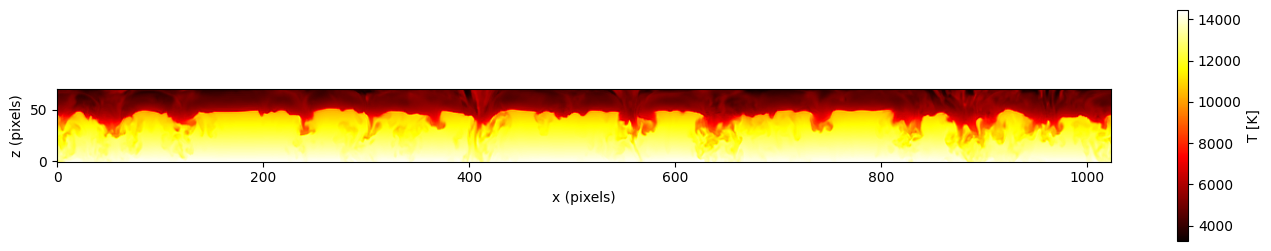

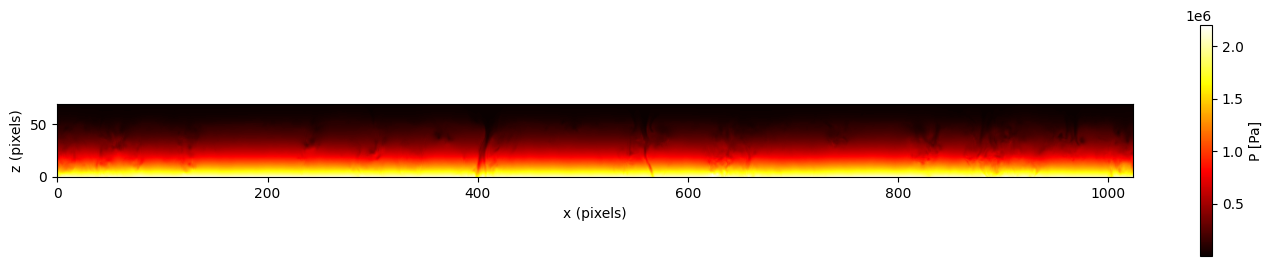

In [4]:
# Lets print out the data for T and P

plt.figure(figsize=(17, 3))
plt.imshow(data_raw[0].data[0, :, 0, :].transpose(1,0), cmap='hot', origin='lower')
plt.xlabel('x (pixels)')
plt.ylabel('z (pixels)')
plt.colorbar(label = "T [K]")
plt.show()

plt.figure(figsize=(17.36, 3))
plt.imshow(data_raw[0].data[1, :, 0, :].transpose(1,0), cmap='hot', origin='lower')
plt.xlabel('x (pixels)')
plt.ylabel('z (pixels)')
plt.colorbar(label = "P [Pa]")
plt.show()

In [5]:
# We will work with one y slice and 100 slices in x

T_sim = data_raw[0].data[0, 0:25, 0, :]
P_sim = data_raw[0].data[1, 0:25, 0, :]
   
np.shape(T_sim) 

(25, 70)

In [6]:
# We define the NN:

class PINN(nn.Module):

    def __init__(self):
        super().__init__()
        layers = []
        sizes = [2] + [32] + [64] + [128] * 2 + [64] + [32] + [2]
        for i in range(len(sizes) - 1): # za svaki sloj
            layers.append(nn.Linear(sizes[i], sizes[i+1])) # linearna transformacija
            if i < len(sizes) - 2: # dodajem aktivaciju osim za izlazni sloj
                layers.append(nn.Tanh())
                
        self.net = nn.Sequential(*layers) # zvezdica da se razbije lista u argumente
        # Sequential kombinuje module u lanac

        for m in self.net: # uzima svaki modul iz sekvencijalnog modela
            if isinstance(m, nn.Linear): # samo linerarni slojevi imaju tezine i bias
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, X):
        return self.net(X)


In [7]:
N_x = len(T_sim[: , 0]) # number of pixels in x
N_z = len(T_sim[0 , :]) # number of pixels in z

# Physical constants
m_sr = 1.23 * 1.66053906660e-27   # kg
k_b = 1.380649e-23               # J/K
g = 274.0                        # m/s^2
z_max = N_z * 24000              # m
x_max = N_x * 24000              # m

T0 = 6000.0
H0 = k_b * T0 / (m_sr * g)
T_max = np.max(T_sim)

In [8]:
x_sim = np.linspace(0, x_max, N_x)
z_sim = np.linspace(0, z_max, N_z)
X, Z = np.meshgrid(x_sim, z_sim, indexing="ij")  # (N_x, N_z)

X_flat = torch.from_numpy(X / x_max).float().reshape(-1, 1)
Z_flat = torch.from_numpy(Z / z_max).float().reshape(-1, 1)    
X_dom = torch.cat([X_flat, Z_flat], dim=1).requires_grad_(True)

# Top boundary (z = z_max)
x_top = torch.from_numpy(X[:, -1] / x_max).float().unsqueeze(1)
z_top = torch.ones_like(x_top)
X_top = torch.cat([x_top, z_top], dim=1)

print("X_dom:", X_dom.shape)
print("X_top:", X_top.shape)

X_dom: torch.Size([1750, 2])
X_top: torch.Size([25, 2])


In [9]:

model = PINN()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
Weights = [1.0, 1.0, 1.0, 1.0] # HSRz, HSRx, T, BCp


In [10]:
P_top = P_sim[: , -1] # [Pa], pritisak na poslednjem sloju
P_top_torch = torch.from_numpy(np.ascontiguousarray(P_top).astype(np.float32)).to(X_dom.device)
logP_top = torch.log(P_top_torch)

T_sim_flat = torch.from_numpy(np.ascontiguousarray(T_sim).astype(np.float32)).reshape(-1, 1).to(X_dom.device)
# Here i use np.ascontiguousarray just in case if values are not contiguous

def pinn_loss():
    # NN output
    Y = model(X_dom)
    logp = Y[:, 0:1] 
    T_reduced = Y[:, 1:2]

    T = T_reduced * T_max

    grads = torch.autograd.grad(
        logp, X_dom,
        grad_outputs=torch.ones_like(logp),
        create_graph=True
    )[0]

    dlogp_dx = grads[:, 0:1]
    dlogp_dz = grads[:, 1:2]

    H = (k_b * T_sim_flat) / (m_sr * g)

    # --------------------
    # PDE residuals
    # --------------------
    loss1 = dlogp_dz + z_max/H   
    loss2 = dlogp_dx               

    # --------------------
    # Temperature loss
    # --------------------
    loss3 = (T - T_sim_flat) / T_max

    # --------------------
    # Boundary condition (TOP)
    # --------------------
    logp_top_pred = model(X_top)[:, 0:1]
    bc_p = logp_top_pred - logP_top  


    # --------------------
    # Weighted MSE losses
    # --------------------
    L1 = Weights[0] * loss1.pow(2).mean()
    L2 = Weights[1] * loss2.pow(2).mean()
    L3 = Weights[2] * loss3.pow(2).mean()
    LP = Weights[3] * bc_p.pow(2).mean()

    total_loss = L1 + L2 + L3 + LP

    return total_loss, L1, L2, L3, LP


In [11]:

epochs = 60000

history = {
    "epoch": [],
    "loss_total": [],
    "loss_dlogp_dz": [],
    "loss_dlogp_dx": [],
    "loss_T": [],
    "bc_p": [],
    "bc_T": [],
}

for epoch in trange(60000, desc="Training"):
    optimizer.zero_grad()

    loss, L1, L2, L3, L4 = pinn_loss()
    loss.backward()
    optimizer.step()
    
    history["loss_total"].append(loss.item())

    if epoch % 60000 == 0:
        history["epoch"].append(epoch)
        history["loss_dlogp_dz"].append(L1.item())
        history["loss_dlogp_dx"].append(L2.item())
        history["loss_T"].append(L3.item())
        history["bc_p"].append(L4.item())
    
        print(f"\nEpoch {epoch}")
        print(f"  total loss   : {loss.item():.3e}")
        print(f"  dlogp/dz     : {L1.item():.3e}")
        print(f"  dlogp/dx     : {L2.item():.3e}")
        print(f"  T loss       : {L3.item():.3e}")
        print(f"  BC logp      : {L4.item():.3e}")



Training:   0%|          | 27/60000 [00:00<07:43, 129.38it/s]


Epoch 0
  total loss   : 1.511e+02
  dlogp/dz     : 8.224e+01
  dlogp/dx     : 4.354e-01
  T loss       : 4.824e-01
  BC logp      : 6.792e+01


Training: 100%|██████████| 60000/60000 [17:49<00:00, 56.10it/s]


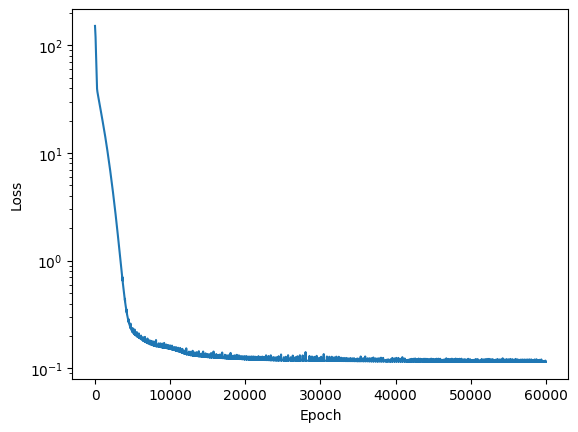

In [12]:
plt.semilogy(history["loss_total"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


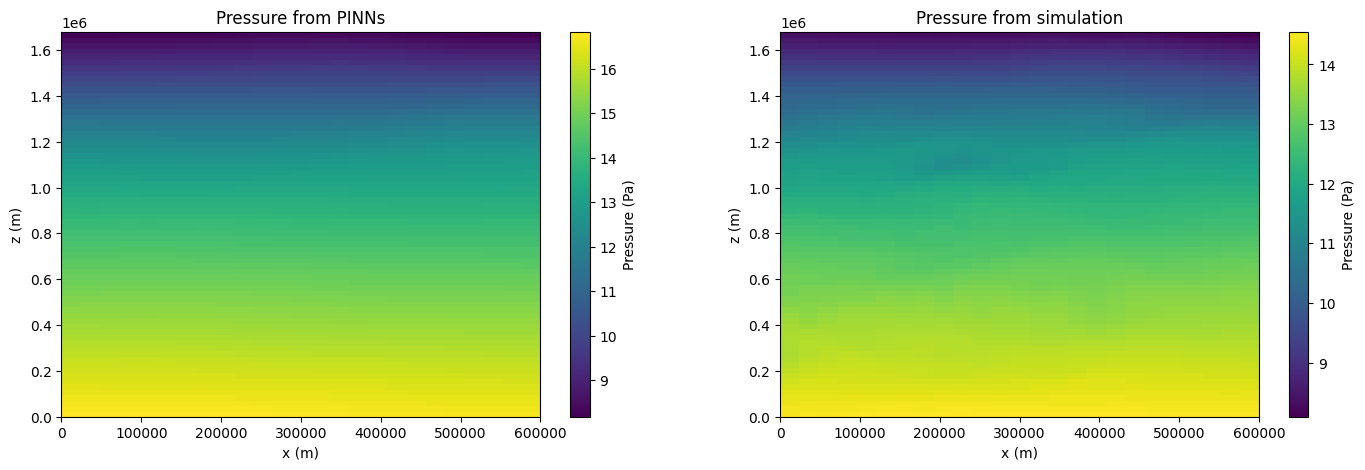

In [13]:
logP_pred_all = model(X_dom)[:,0].detach().numpy().reshape(N_x, N_z)

fig, ax = plt.subplots(1, 2, figsize=(17,5))
ax[0].imshow(logP_pred_all.transpose(1,0))
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('z (m)')
fig.colorbar(ax[0].imshow(logP_pred_all.transpose(1,0), extent=[0, x_max, 0, z_max], aspect='auto', origin='lower', cmap='viridis'), label='Pressure (Pa)')
ax[0].set_title('Pressure from PINNs')

ax[1].imshow(np.log(P_sim))
ax[1].set_xlabel('x (m)')
ax[1].set_ylabel('z (m)')
fig.colorbar(ax[1].imshow(np.log(P_sim).transpose(1,0), extent=[0, x_max, 0, z_max], aspect='auto', origin='lower', cmap='viridis'), label='Pressure (Pa)')
ax[1].set_title('Pressure from simulation')
#plt.suptitle('Pressure Comparison: PINN Prediction vs Simulation')
plt.show()

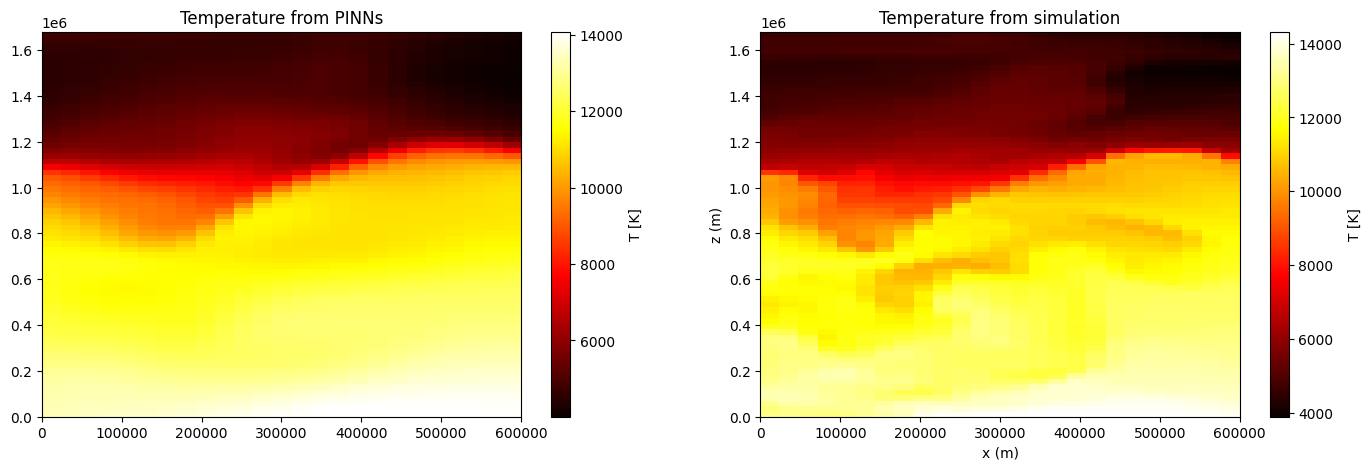

In [14]:
XZ_full = torch.cat([X_flat, Z_flat], dim=1).float()
T_pred_full = model(XZ_full)[:,1]
T_pred_full = T_pred_full * T_max  # Scale T to physical range
T_pred_full = T_pred_full.detach().numpy().reshape(N_x, N_z)

fig, ax = plt.subplots(1, 2, figsize = (17,5))
ax[0].imshow(T_pred_full.transpose(1,0))
fig.colorbar(ax[0].imshow(T_pred_full.transpose(1,0), extent=[0, x_max, 0, z_max], aspect='auto', origin='lower', cmap='hot'), label = "T [K]")
ax[0].set_title('Temperature from PINNs')

ax[1].imshow(T_sim.transpose(1,0))
fig.colorbar(ax[1].imshow(T_sim.transpose(1,0), extent=[0, x_max, 0, z_max], aspect='auto', origin='lower', cmap='hot'), label = "T [K]")
ax[1].set_title('Temperature from simulation')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.show()  